In [13]:
#How to reuse existing weights of CNN and modify ANN(FC) layer as per our custom dataset

In [1]:
import tensorflow as tf

2025-03-20 19:53:02.151509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Extract the Zip File ---- Step required in colab if zip file uploaded

!unzip fruits-small.zip

Archive:  fruits-small.zip
   creating: fruits-small/
   creating: fruits-small/data/
   creating: fruits-small/data/Training/
   creating: fruits-small/data/Training/Banana/
  inflating: fruits-small/data/Training/Banana/0_100.jpg  
  inflating: fruits-small/data/Training/Banana/104_100.jpg  
  inflating: fruits-small/data/Training/Banana/107_100.jpg  
  inflating: fruits-small/data/Training/Banana/10_100.jpg  
  inflating: fruits-small/data/Training/Banana/112_100.jpg  
  inflating: fruits-small/data/Training/Banana/117_100.jpg  
  inflating: fruits-small/data/Training/Banana/118_100.jpg  
  inflating: fruits-small/data/Training/Banana/119_100.jpg  
  inflating: fruits-small/data/Training/Banana/11_100.jpg  
  inflating: fruits-small/data/Training/Banana/120_100.jpg  
  inflating: fruits-small/data/Training/Banana/121_100.jpg  
  inflating: fruits-small/data/Training/Banana/122_100.jpg  
  inflating: fruits-small/data/Training/Banana/123_100.jpg  
  inflating: fruits-small/data/Train

In [3]:
# Preprocessing --- Goal is to make the data compatible for CNN
# Tensorflow by default offers direct class to achieve preprocessing

# ImageGenerators

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [4]:
# Pass my images

trainImageData = train_generator.flow_from_directory('fruits-small/data/Training',
                                                     batch_size=20, #How many images to pass per tick
                                                     class_mode='categorical', #binary --- Binary Classification | categorical ---- Multi-class classification
                                                     target_size=(224,224))

testImageData = test_generator.flow_from_directory('fruits-small/data/Validation',
                                                     batch_size=20, #How many images to pass per tick
                                                     class_mode='categorical', #binary --- Binary Classification | categorical ---- Multi-class classification
                                                     target_size=(224,224))

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [ ]:
# Reuse the VGG16 architecture

# Refs: 
# https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide\
# https://arxiv.org/pdf/1409.1556

#include_top=False ------------------> Removing the FC layer of the original architecture

vgg1 = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step


In [6]:
#lock the weights of Vgg convolution layer

for layer in vgg1.layers:
  layer.trainable=False

In [ ]:
# Create FC Layer for my custom dataset

#flatten
flatten = tf.keras.layers.Flatten()
#H1
dense1 = tf.keras.layers.Dense(25088, activation="relu")
#H2
dense2 = tf.keras.layers.Dense(4096, activation="relu")
#H3
dense3 = tf.keras.layers.Dense(4096, activation="relu")
#output layer
output = tf.keras.layers.Dense(7,activation="softmax")

#Create Final Model

model = tf.keras.models.Sequential([
    vgg1,
    flatten,
    dense1,
    dense2,
    output
])

In [8]:
# Define the model with an explicit Input layer
input_layer = tf.keras.layers.Input(shape=[224, 224, 3])
x = vgg1(input_layer)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4000, activation="relu")(x)
x = tf.keras.layers.Dense(2000, activation="relu")(x)
output_layer = tf.keras.layers.Dense(7, activation="softmax")(x)

# Create the final model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4000)           │   100,356,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2000)           │     8,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │        14,007 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,086,695 (469.54 MB)

 Trainable params: 108,372,007 (413.41 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
#Compile
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [11]:
model.fit(trainImageData,
          validation_data=testImageData,
          epochs=1,
          steps_per_epoch=int(len(trainImageData.filenames) / trainImageData.batch_size),
          validation_steps=int(len(testImageData.filenames) / testImageData.batch_size))

/opt/anaconda3/envs/ipykernel_py3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.8925 - loss: 32.1426 - val_accuracy: 0.9877 - val_loss: 1.4618


In [14]:
img = tf.keras.preprocessing.image.load_img('banana.png', target_size=(224, 224))

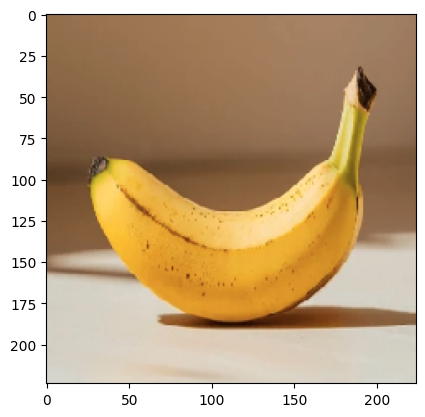

In [15]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [16]:
imgArray= tf.keras.preprocessing.image.img_to_array(img)
imgArray.shape

(224, 224, 3)

In [17]:
import numpy as np
compatibleArray = np.expand_dims(imgArray, axis=0)
compatibleArray.shape

(1, 224, 224, 3)

In [18]:
model.predict(compatibleArray)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [19]:
trainImageData.class_indices.items()

dict_items([('Banana', 0), ('Lemon', 1), ('Mango', 2), ('Orange', 3), ('Pineapple', 4), ('Pomegranate', 5), ('Strawberry', 6)])

In [20]:
{v:k for k,v in trainImageData.class_indices.items()} [ np.argmax(model.predict(compatibleArray)) ]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


'Banana'

In [ ]:
# Resnet50
# MobileNet any version
# vgg 19
# Xception

In [ ]:
# Train model for cats and dogs dataset (VGG16, VGG19, RESNET)

In [21]:
!nvidia-smi

zsh:1: command not found: nvidia-smi
